In [1]:
from plot_funcs import (get_results, get_mean_avg_ranks,
                        get_results_df, plot_avg_ranks, get_ranks_sizes)
from funcs import save_stats_summary
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols, rlm

Most of the utilities for loading and plotting results are defined in other functions, these notebooks are for making sense of them.

First we will consider loading the raw results.

In [2]:
results = get_results('../exp/results')

Found: 64530 Incomplete: 0


These are still in a difficult format to work with, we will plot with results for just the elastic net models and just random parcellations.

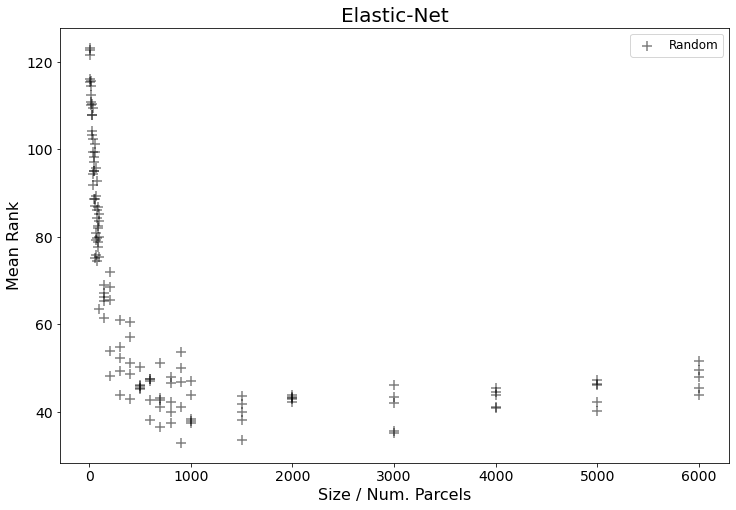

In [3]:
plot_avg_ranks(results, random=True, model='elastic')
plt.savefig('Figures/simple_example.png', dpi=300, bbox_inches='tight')

Next plot as log-log

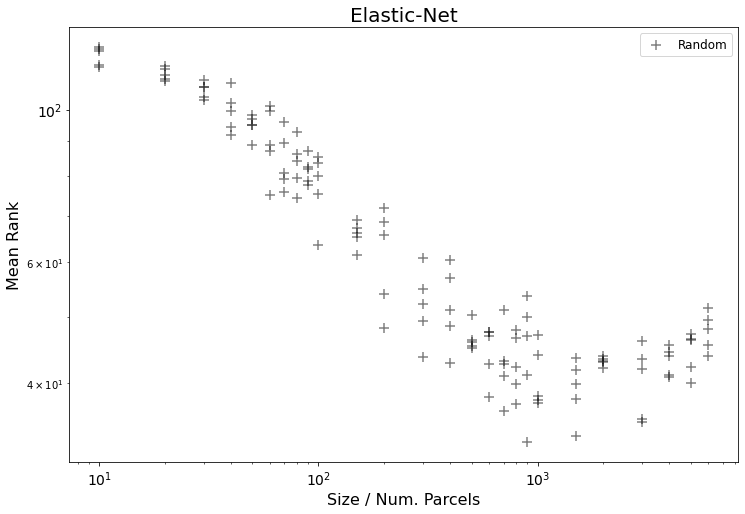

In [4]:
plot_avg_ranks(results, random=True, log=True, model='elastic')
plt.savefig('Figures/simple_example_log.png', dpi=300, bbox_inches='tight')

We can use the following function to get these same results in a dataframe before plotting.

In [5]:
r_df = get_ranks_sizes(results, models=['elastic'], log=True,
                       threshold=False, random=True)
r_df = r_df.sort_values(by='Size')
r_df.head()

,Parcellation_Type,Mean_Rank,Size
14,Random,2.084537,1.0
10,Random,2.090689,1.0
11,Random,2.065123,1.0
12,Random,2.088569,1.0
13,Random,2.062289,1.0


We next fit a model simply from log10 mean rank ~ size

In [6]:
model = ols('Mean_Rank ~ Size', data=r_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     599.3
Date:                Tue, 29 Jun 2021   Prob (F-statistic):           3.98e-50
Time:                        12:41:51   Log-Likelihood:                 162.17
No. Observations:                 130   AIC:                            -320.3
Df Residuals:                     128   BIC:                            -314.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2678      0.021    109.545      0.000       2.227       2.309
Size          -0.1956      0.008    -24.481      0.000      -0.211      -0.180
==============================================================================
Omnibus:                        0.254   Durbin-Watson:                   0.716
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.336
Skew:                          -0.101   Prob(JB):                        0.845
Kurtosis:                       2.856   Cond. No.                         9.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's add the fitted model to the plot from before

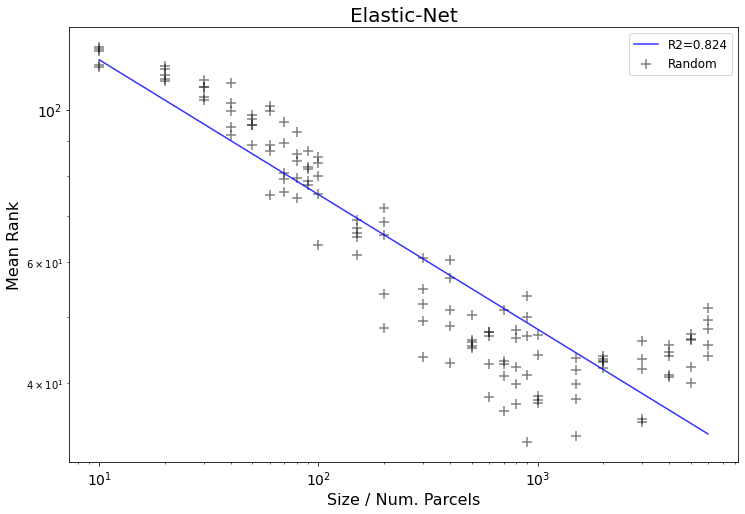

In [7]:
# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
o_size = 10 ** r_df['Size']

# Line of pred. fit
p_fit = 10 ** model.params.Intercept * (o_size **(model.params.Size))

# Plot line of fit
ax.plot(o_size, p_fit, color='blue',
        alpha=.8, label=f'R2={model.rsquared:.3f}')

# Plot data points as before
plot_avg_ranks(results, random=True, log=True,
               model='elastic', ax=ax)

plt.savefig('Figures/simple_example_log_with_fit.png', dpi=300, bbox_inches='tight')

Let's now instead of modelling all results, model just those estimated to be within the power law scaling.

0 -25
Smallest size: 10.0
Largest size: 1500.0


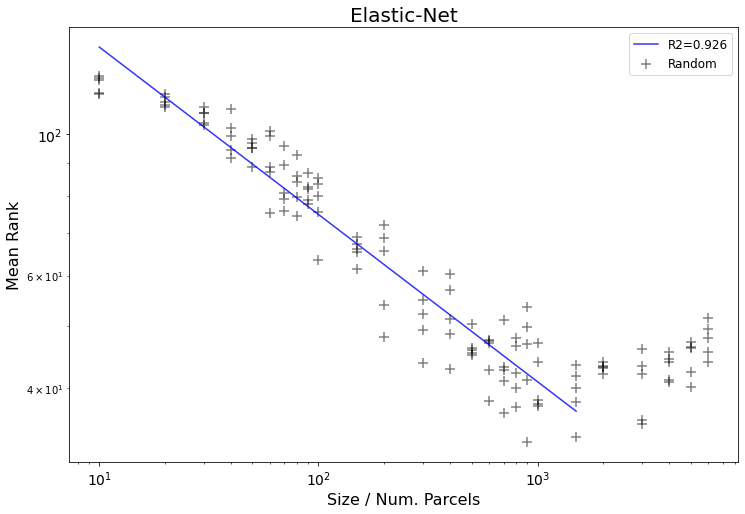

In [8]:
r_df_thresh = get_ranks_sizes(results, models=['elastic'], log=True,
                              threshold=True, random=True).sort_values(by='Size')
model = ols('Mean_Rank ~ Size', data=r_df_thresh).fit()

# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
o_size = 10 ** r_df_thresh['Size']

# Line of pred. fit
p_fit = 10 ** model.params.Intercept * (o_size **(model.params.Size))

# Plot line of fit
ax.plot(o_size, p_fit, color='blue',
        alpha=.8, label=f'R2={model.rsquared:.3f}')

# Plot data points as before
plot_avg_ranks(results, random=True, log=True,
               model='elastic', ax=ax)

# Save stats summary as html
save_stats_summary(model, 'stats_example')

# Save Fig
plt.savefig('Figures/simple_example_log_with_fit2.png', dpi=300, bbox_inches='tight')

Now let's consider instead of just looking at the Elastic-Net, averaging across all three pipelines.

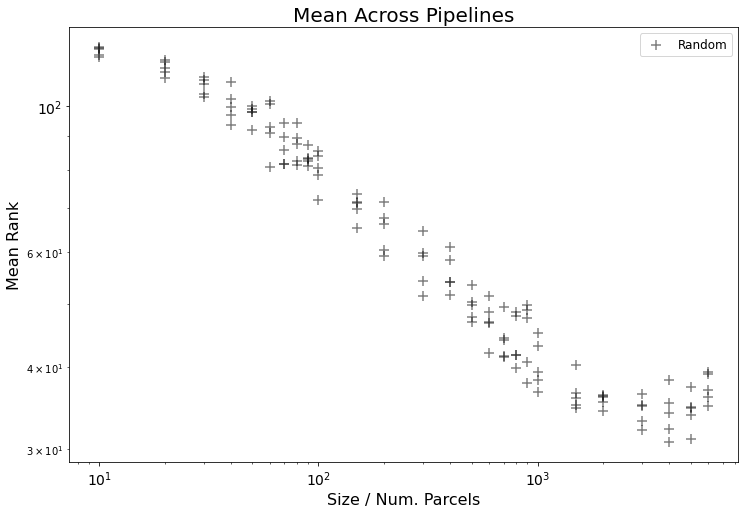

In [9]:
plot_avg_ranks(results, random=True, log=True, model=['svm', 'elastic', 'lgbm'])
plt.savefig('Figures/all_example_log.png', dpi=300, bbox_inches='tight')

Let's also look at multiple parcellations at once

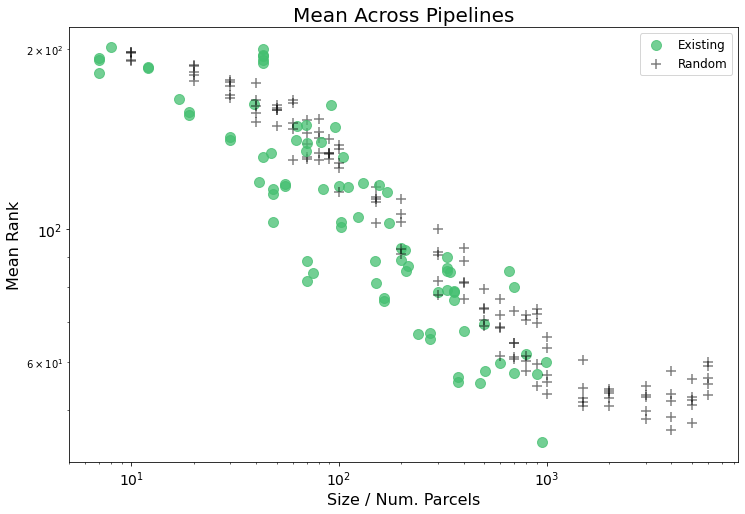

In [10]:
plot_avg_ranks(results, random=True, base=True, log=True, model=['svm', 'elastic', 'lgbm'])
plt.savefig('Figures/all_example_log_2parcs.png', dpi=300, bbox_inches='tight')

0 -17
Smallest size: 7.0
Largest size: 3000.0


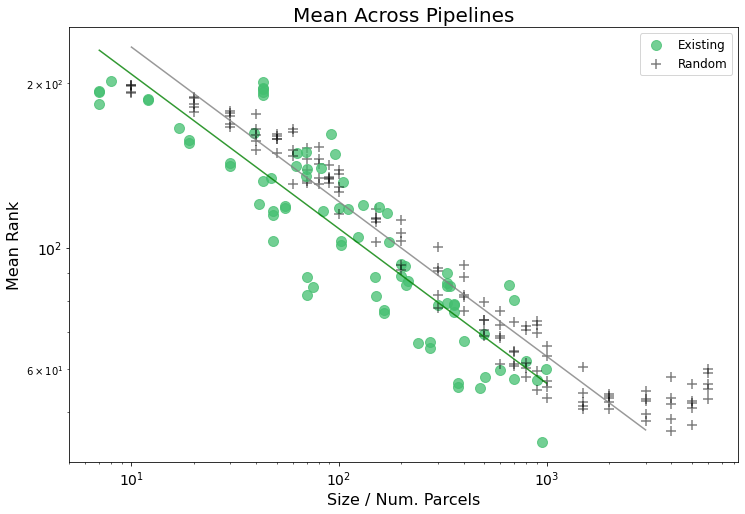

In [11]:
# Get raw df
r_df = get_ranks_sizes(results, log=True, models=['svm', 'elastic', 'lgbm'], threshold=True,
                       base=True, random=True).sort_values(by='Size')

# Model
model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()

# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Existing']
r_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Random']

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Parcellation_Type)[T.Random]'])
r_fit = r_intercept * (r_size **(model.params.Size))

# Plot lines of fit
ax.plot(e_size, e_fit, color='green', alpha=.8)
ax.plot(r_size, r_fit, color='gray', alpha=.8)

# Add main plot
plot_avg_ranks(results, random=True, base=True,
               log=True, model=['svm', 'elastic', 'lgbm'], ax=ax)

# Save stats summary as html
save_stats_summary(model, 'stats_example2')

# Save Fig
plt.savefig('Figures/all_with_fit_example.png', dpi=300, bbox_inches='tight')

What if we allow for interactions?

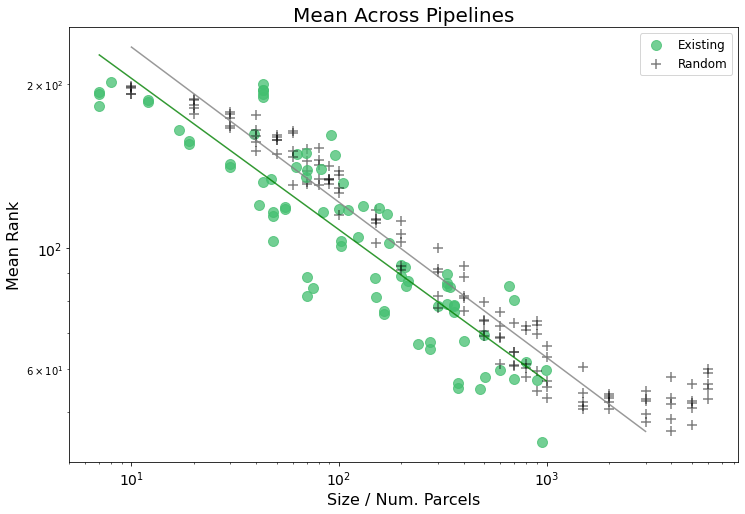

In [12]:
# Model w/ interaction
model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()

# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Existing']
r_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Random']

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Parcellation_Type)[T.Random]'])
r_fit = r_intercept * (r_size ** (model.params.Size + model.params['Size:C(Parcellation_Type)[T.Random]']))

# Plot lines of fit
ax.plot(e_size, e_fit, color='green', alpha=.8)
ax.plot(r_size, r_fit, color='gray', alpha=.8)

# Add main plot
plot_avg_ranks(results, random=True, base=True,
               log=True, model=['svm', 'elastic', 'lgbm'], ax=ax)

# Save stats summary as html
save_stats_summary(model, 'stats_example3')

# Save Fig
plt.savefig('Figures/all_with_fit_example_interaction.png', dpi=300, bbox_inches='tight')

Look at some example specific results - The point of this example being to point out that target variables exist on different scales of predictability.

In [13]:
print(results['random_1000_1---elastic---anthro_waist_cm'][0][0])
print(results['random_1000_1---elastic---cbcl_scr_syn_rulebreak_r'][0][0])
print((results['random_1000_1---elastic---anthro_waist_cm'][0][0] + results['random_1000_1---elastic---cbcl_scr_syn_rulebreak_r'][0][0]) / 2)
print()

print(results['random_10_1---elastic---anthro_waist_cm'][0][0])
print(results['random_10_1---elastic---cbcl_scr_syn_rulebreak_r'][0][0])
print((results['random_10_1---elastic---anthro_waist_cm'][0][0] + results['random_10_1---elastic---cbcl_scr_syn_rulebreak_r'][0][0]) / 2)

0.09489346853757999
0.01645089771154846
0.05567218312456423

0.028499362630581192
0.007475725963695367
0.01798754429713828
